In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from models import spatial_flu as sf
from scipy import integrate

reload(sf);

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]
TMAX = 50

# Modelling setup

The model is:

$$\dot{S} = -\beta SI + \gamma R - vS -\mu S + \mu + d_S \nabla^2S$$
$$\dot{I} = \beta SI -\alpha I -\mu I + d_I \nabla^2I$$
$$\dot{R} = \alpha I - \gamma R + vS - \mu R + d_R \nabla^2R$$

i.e. a typical diffusion-reaction equation.

This is solved as a typical ODE by approximating the $\nabla^2$ operator via finite differences. We choose to apply Neumann conditions along the boundary (no flow of people outside the domain of interest). We also specify that the coefficients of diffusion ($d_S, d_I, d_R$) are homogeneous, and not spatially dependent. This turns the diffusion terms into simple linear terms.

Aspects that are common that this model neglects are:
- Migration
- Long-range travel
- Structured stratification.

This model considers that force of infection effects from distant cells to be an effect of diffusion, as opposed to explicitly modelled.

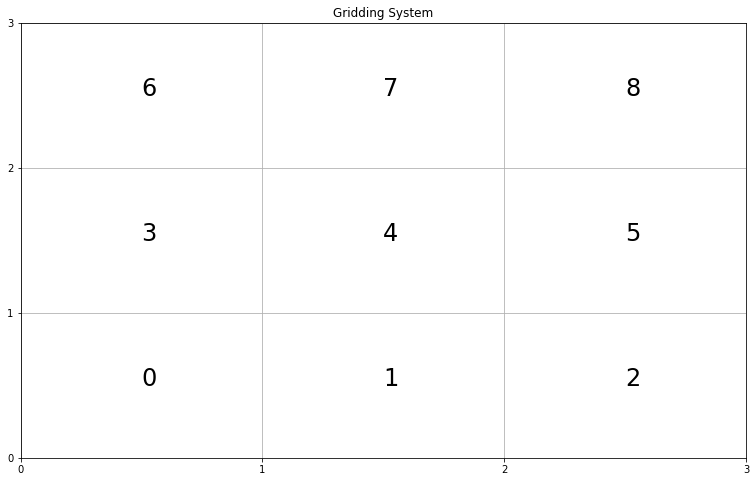

In [3]:
plt.figure()
plt.title("Gridding System")
plt.axis([0, 3, 0, 3],)
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.grid()
for i in range(3):
    for j in range(3):
        plt.text(i+0.5, j+0.5, str(i+j*3), fontsize=24)

In [4]:
# [death rate, r_0, 1/immunity duration, vaccination rate/4, 1/infectious period, 
#  chance S moves to adjacent cell, chance I moves, chance R moves]
parameters = [0.01, 1.6, 1/3, (0.2)/4, 1/(1/26), 1, 0.01, 0.1]

func = lambda t, y: sf.model(t, y, parameters)

infect_fraction = 1e-5
initial_state = [1]*9 + [0]*9 + [0]*9
initial_state[4::9] = [1-infect_fraction, infect_fraction, 0]
initial_state = np.array(initial_state)*100000

solution = integrate.solve_ivp(func, [0, TMAX], initial_state, max_step=1/12, dense_output=True)

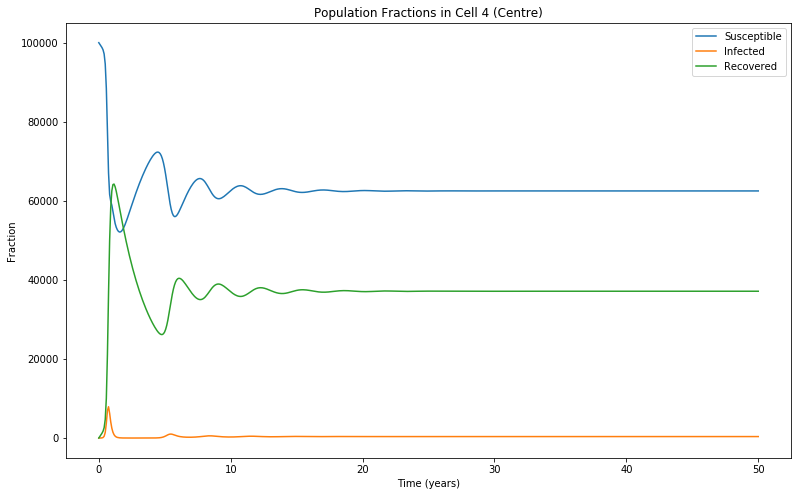

In [5]:
plt.figure()
plt.plot(solution.t, solution.y[4::9].T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cell 4 (Centre)")
plt.legend(["Susceptible", "Infected", "Recovered"])

The centre cell displays behaviours similar to the non-diffusion model. We see the same two "outbreak" peaks in the infected fractions.

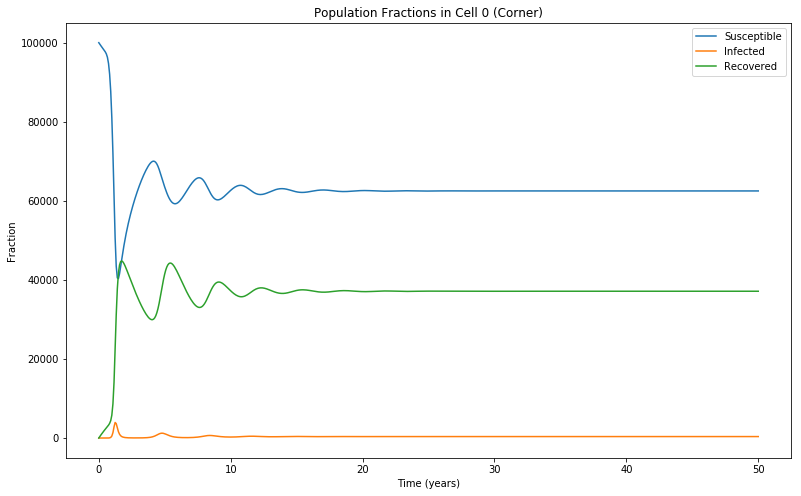

In [6]:
plt.figure()
plt.plot(solution.t, solution.y[::9].T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cell 0 (Corner)")
plt.legend(["Susceptible", "Infected", "Recovered"])

Text(0.5, 1.0, 'Population Fractions in All Cells')

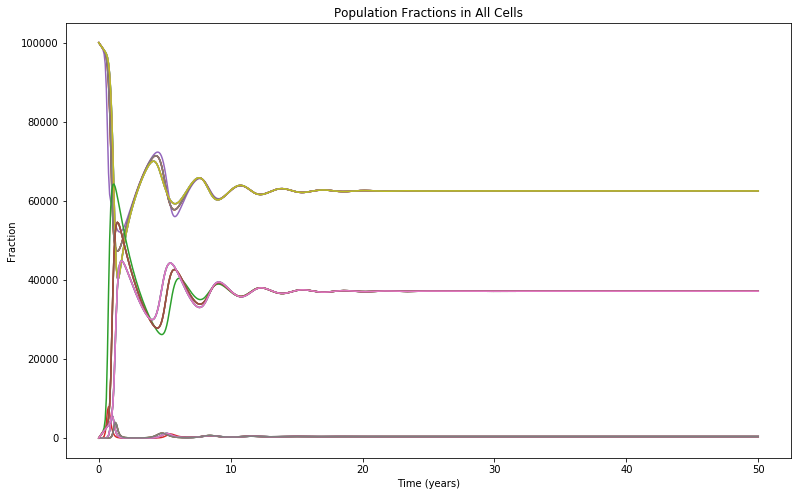

In [7]:
plt.figure()
plt.plot(solution.t, solution.y.T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in All Cells")

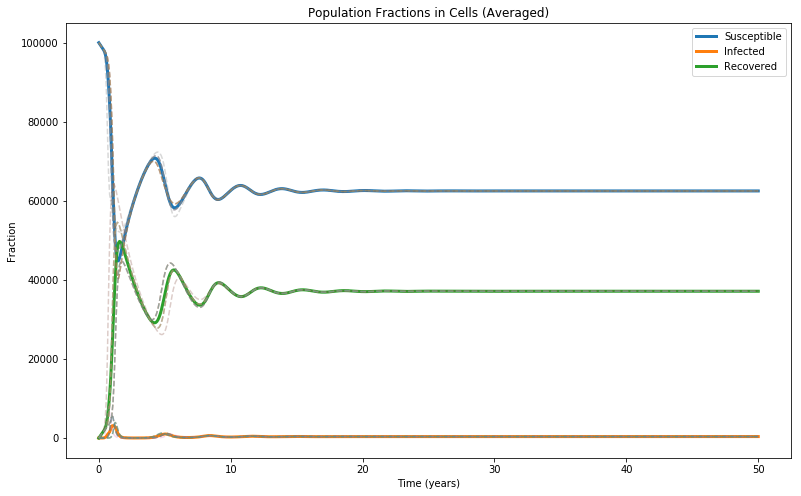

In [8]:
def aug(array, section_size):
    return np.vstack([np.mean(array[i:i+section_size], axis=0) for i in range(0, len(array), section_size)])

averagey = aug(solution.y, 9)

plt.figure()
plt.plot(solution.t, averagey.T, linewidth=3)
plt.plot(solution.t, solution.y.T, '--', alpha=0.3)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cells (Averaged)")
plt.legend(["Susceptible", "Infected", "Recovered"])

Text(0, 0.5, 'Infecteds')

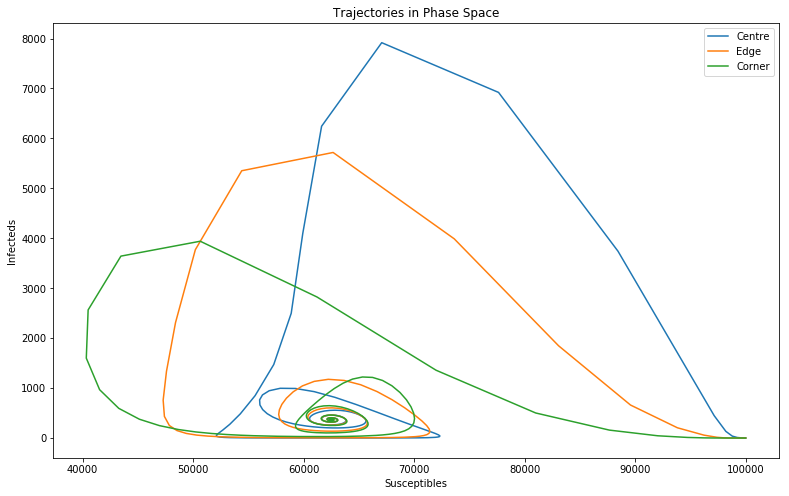

In [9]:
plt.figure()
# plt.plot(averagey[0], averagey[1])
plt.plot(solution.y[4], solution.y[13])
plt.plot(solution.y[1], solution.y[10])
plt.plot(solution.y[0], solution.y[9])

plt.legend(["Centre", "Edge", "Corner"])
plt.title("Trajectories in Phase Space")
plt.xlabel("Susceptibles")
plt.ylabel("Infecteds")

## A finer grid

In [10]:
# Extend the gridding system

from models import fine_spatial_flu as fsf
reload(fsf)

<module 'models.fine_spatial_flu' from 'D:\\Documents\\phd\\self-harm\\models\\fine_spatial_flu.py'>

In [11]:
print(f"{fsf.N} by {fsf.N} grid, Neumann boundaries")

21 by 21 grid, Neumann boundaries


In [12]:
assert all(np.sum(fsf.D, axis=1) == 0)
J = np.zeros((fsf.N**2, fsf.N**2))
J[np.arange(0, fsf.N**2), np.arange(fsf.N**2-1,-1,-1)] = 1
assert np.allclose(fsf.D@J, J@fsf.D)

In [13]:
parameters = [0.01, 1.6, 1/3, (0.2)/4, 1/(1/26), 0.1, 0.001, 0.01]

func = lambda t, y: fsf.model(t, y, parameters)

initial_state = fsf.default_ic()

solution_fine = integrate.solve_ivp(func, [0, TMAX], initial_state, dense_output=True, first_step=1/12)

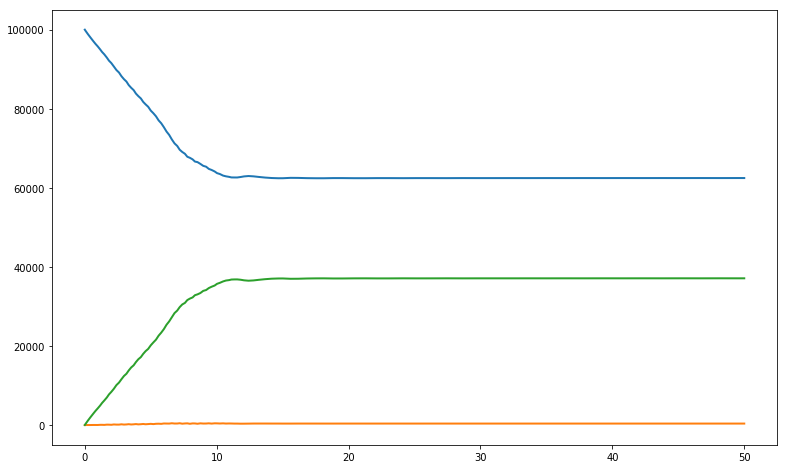

In [14]:
plt.figure()
plt.plot(solution_fine.t, aug(solution_fine.y, fsf.N**2).T, linewidth=2);

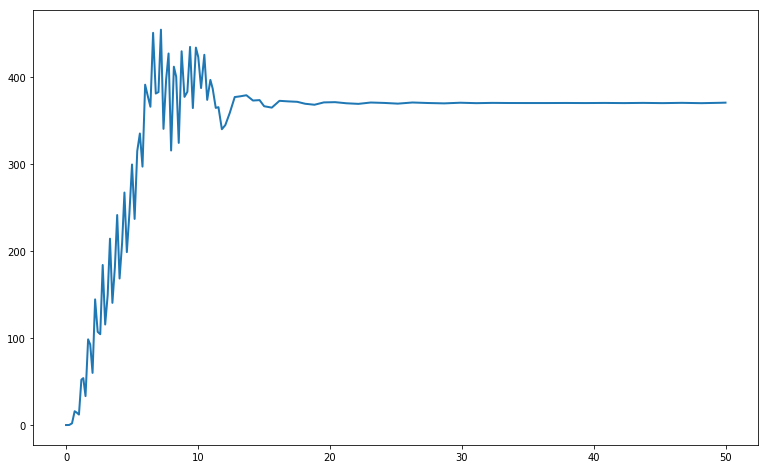

In [15]:
plt.figure()
plt.plot(solution_fine.t, aug(solution_fine.y, fsf.N**2)[1,:].T, linewidth=2);

Text(0, 0.5, 'Fraction')

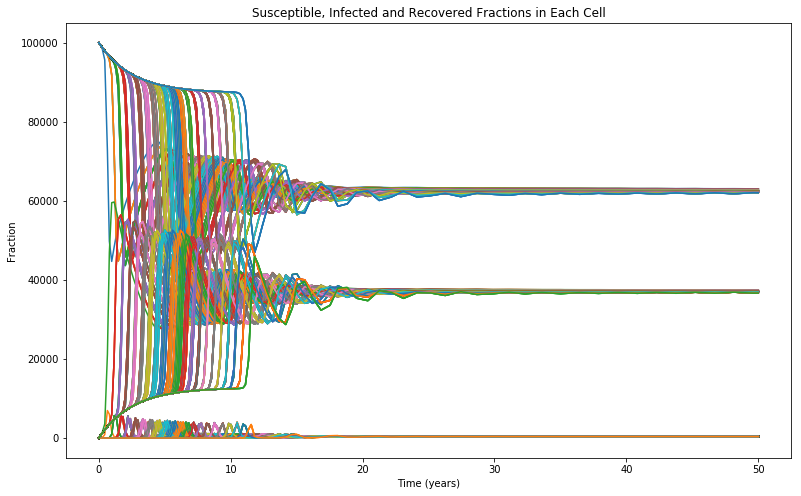

In [16]:
plt.figure()
plt.plot(solution_fine.t, solution_fine.y.T)
plt.title("Susceptible, Infected and Recovered Fractions in Each Cell")
plt.xlabel("Time (years)")
plt.ylabel("Fraction")

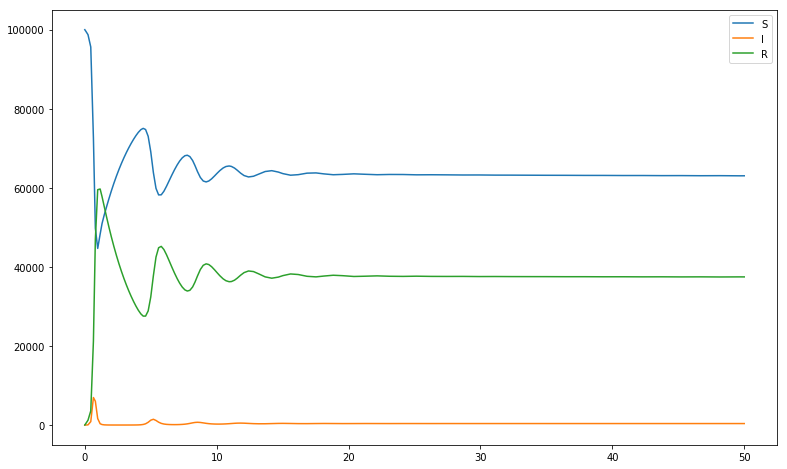

In [17]:
plt.figure()
centre = int(fsf.N//2)
plt.plot(solution_fine.t, solution_fine.y[centre*fsf.N+centre::fsf.N**2].T)
plt.legend("SIR")

In [18]:
def get_part(state, part, size):
    return state[size**2*part:size**2*(part+1)].reshape(size, size)

Text(0, 0.5, 'Fraction')

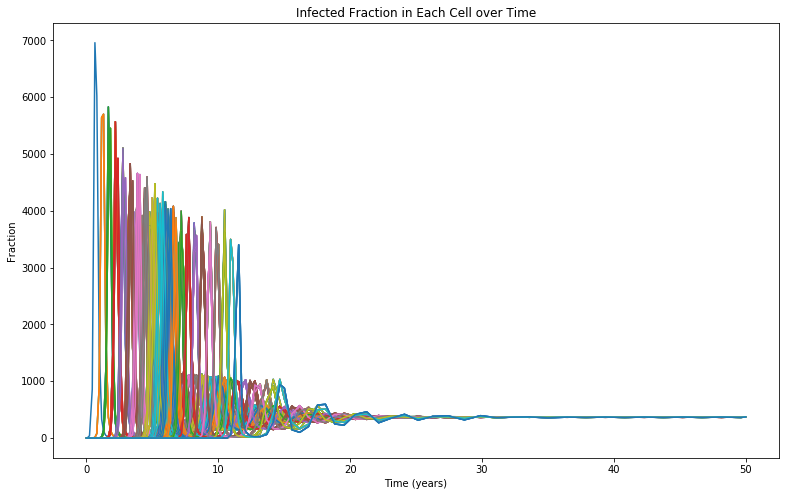

In [19]:
plt.figure()
plt.plot(solution_fine.t, solution_fine.y[fsf.N**2:fsf.N**2*2].T);
plt.title("Infected Fraction in Each Cell over Time")
plt.xlabel("Time (years)")
plt.ylabel("Fraction")

In [20]:
from ipywidgets import interact, FloatSlider

@interact
def filler_function_cell_code_block_0(time=FloatSlider(value=0, min=0, max=TMAX, step=0.25)):
    plt.figure()
    plt.title(f"Infected Fraction over Cells at t={time} years")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.imshow(get_part(solution_fine.sol(time), 1, fsf.N), vmin=0, vmax=5500)
    plt.colorbar()

interactive(children=(FloatSlider(value=0.0, description='time', max=50.0, step=0.25), Output()), _dom_classes…

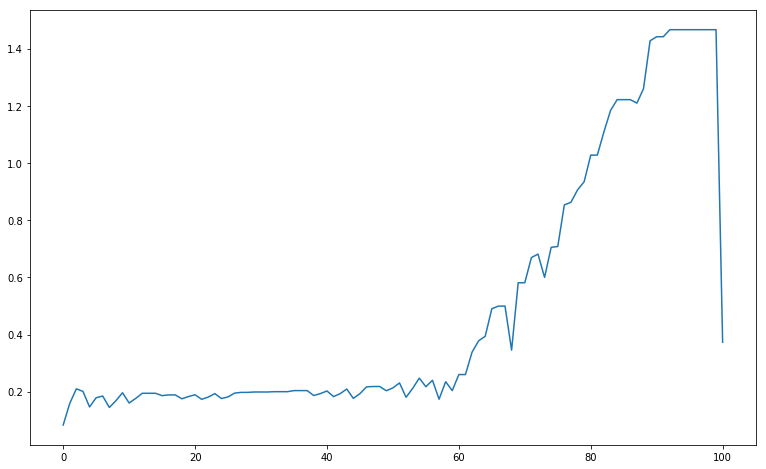

In [21]:
plt.plot(np.diff(solution_fine.t))